In [63]:
import numpy as np
import pandas as pd

import progressbar

import heapq
from collections import defaultdict

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import normalize
from sklearn.neighbors import KDTree

%reload_ext line_profiler

In [163]:
def euclidian_distance(x, y):
    return np.linalg.norm(x-y)

class NearestModel:
    def __init__(self, k, use_kdtree=False):
        self.k = k
        self.use_kdtree = use_kdtree
           
    def train(self, X, y):
        if self.use_kdtree:
            self.tree = KDTree(X)
        else:
            self.X = X
        self.y = y
    
    def predict(self, values):
        return [self.predict_one(v) for v in values]
    
    def predict_one(self, value):
        nearest = self._find_k_nearest(value)
        weights = defaultdict(lambda : 0.)
        
        for n in nearest:
            weights[self.y[n[1]]] += n[0]
        
        return max(weights, key=weights.get)
    
class KNN_model(NearestModel):
    def _find_k_nearest(self, x):
        if self.use_kdtree:
            res = self.tree.query([x], self.k)
            return [(1/(1+d), idx) for d, idx in zip(res[0][0], res[1][0])]
        else:
            return heapq.nlargest(self.k, [(1/(1+euclidian_distance(x, y)), idx) for idx, y in enumerate(self.X)])
    
class RNN_model(NearestModel):
    def _find_k_nearest(self, x):
        if self.use_kdtree:
            res = self.tree.query_radius([x], self.k, return_distance=True)
            return [(1/(1+d), idx) for idx, d in zip(res[0][0], res[1][0])]
        else:
            data = [(euclidian_distance(x, y), idx) for idx, y in enumerate(self.X) if euclidian_distance(x, y) <= self.k]    
            return [(1/(1+v[0]), v[1]) for v in data]
    
    def predict_one(self, value):
        nearest = self._find_k_nearest(value)
        
        if len(nearest) == 0:
            return -1
        
        weights = defaultdict(lambda : 0.)
        
        for n in nearest:
            weights[self.y[n[1]]] += n[0]
        
        return max(weights, key=weights.get)

In [164]:
def leave_one_out(model, X, y):
    correct = 0
    bar = progressbar.ProgressBar(widgets=[
    ' [', progressbar.Timer(), '] ', progressbar.Percentage(),
    progressbar.Bar(),
    ' (', progressbar.ETA(), ') ',
    ])
    for idx in bar(xrange(len(X))):
        X_test = X[idx]
        y_test = y[idx]
        
        X_train = np.delete(X, (idx), axis=0)
        y_train = np.delete(y, (idx), axis=0)
        
        model.train(X_train, y_train)
        res = model.predict_one(X_test)
        if res == y_test:
            correct += 1
    
    return 1.*correct/len(y)

In [165]:
data = pd.read_csv('spambase.csv')
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [166]:
X = data.drop(['label'], axis=1).as_matrix()
y = data['label'].as_matrix()

In [173]:
def compare_models(X, y, k_values, r_values, use_kdtree=False):
    knn_res = list()
    sk_res = list()
    for k, r in zip(k_values, r_values):
        print 'LOO for with k={}'.format(k)
        model = KNN_model(k, use_kdtree=use_kdtree)
        knn_acc = leave_one_out(model, X, y)
        
        sk_clf = KNeighborsClassifier(k)
        loo = LeaveOneOut()
        sk_acc = np.mean(cross_val_score(sk_clf, X, y, cv = loo, n_jobs=4))
        
        knn_res.append(knn_acc)
        sk_res.append(sk_acc)
    
    plt.plot(k_values, knn_res, label='knn model')
    plt.plot(k_values, sk_res, label='scikit model')
    plt.legend()
    
    axes = plt.gca()
    axes.set_ylim([0.7, 0.9])

LOO for with k=1


 [Elapsed Time: 0:03:30] 100%|###############################| (Time: 0:03:30) 


LOO for with k=2


 [Elapsed Time: 0:03:32] 100%|###############################| (Time: 0:03:32) 


LOO for with k=3


 [Elapsed Time: 0:03:28] 100%|###############################| (Time: 0:03:28) 


LOO for with k=4


 [Elapsed Time: 0:03:35] 100%|###############################| (Time: 0:03:35) 


LOO for with k=5


 [Elapsed Time: 0:03:37] 100%|###############################| (Time: 0:03:37) 


LOO for with k=6


 [Elapsed Time: 0:03:33] 100%|###############################| (Time: 0:03:33) 


LOO for with k=7


 [Elapsed Time: 0:03:36] 100%|###############################| (Time: 0:03:36) 


LOO for with k=8


 [Elapsed Time: 0:03:41] 100%|###############################| (Time: 0:03:41) 


LOO for with k=9


 [Elapsed Time: 0:03:42] 100%|###############################| (Time: 0:03:42) 


LOO for with k=10


 [Elapsed Time: 0:03:38] 100%|###############################| (Time: 0:03:38) 


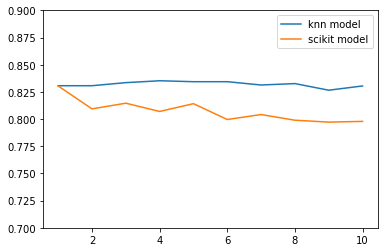

In [201]:
k_values = range(1, 11)
compare_models(X, y, k_values, r_values, use_kdtree=False)

LOO for with k=1


 [Elapsed Time: 0:00:31] 100%|###############################| (Time: 0:00:31) 


LOO for with k=2


 [Elapsed Time: 0:00:32] 100%|###############################| (Time: 0:00:32) 


LOO for with k=3


 [Elapsed Time: 0:00:31] 100%|###############################| (Time: 0:00:31) 


LOO for with k=4


 [Elapsed Time: 0:00:31] 100%|###############################| (Time: 0:00:31) 


LOO for with k=5


 [Elapsed Time: 0:00:32] 100%|###############################| (Time: 0:00:32) 


LOO for with k=6


 [Elapsed Time: 0:00:31] 100%|###############################| (Time: 0:00:31) 


LOO for with k=7


 [Elapsed Time: 0:00:32] 100%|###############################| (Time: 0:00:32) 


LOO for with k=8


 [Elapsed Time: 0:00:32] 100%|###############################| (Time: 0:00:32) 


LOO for with k=9


 [Elapsed Time: 0:00:31] 100%|###############################| (Time: 0:00:31) 


LOO for with k=10


 [Elapsed Time: 0:00:31] 100%|###############################| (Time: 0:00:31) 


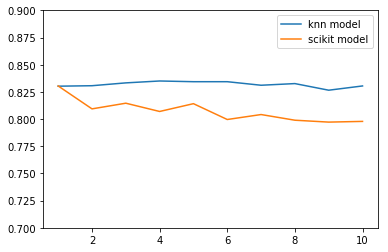

In [174]:
k_values = range(1, 11)
compare_models(X, y, k_values, use_kdtree=True)

LOO for with k=1


 [Elapsed Time: 0:01:31] 100%|###############################| (Time: 0:01:31) 


LOO for with k=2


 [Elapsed Time: 0:01:30] 100%|###############################| (Time: 0:01:30) 


LOO for with k=3


 [Elapsed Time: 0:01:31] 100%|###############################| (Time: 0:01:31) 


LOO for with k=4


 [Elapsed Time: 0:01:31] 100%|###############################| (Time: 0:01:31) 


LOO for with k=5


 [Elapsed Time: 0:01:30] 100%|###############################| (Time: 0:01:30) 


LOO for with k=6


 [Elapsed Time: 0:01:32] 100%|###############################| (Time: 0:01:32) 


LOO for with k=7


 [Elapsed Time: 0:01:32] 100%|###############################| (Time: 0:01:32) 


LOO for with k=8


 [Elapsed Time: 0:01:31] 100%|###############################| (Time: 0:01:31) 


LOO for with k=9


 [Elapsed Time: 0:01:29] 100%|###############################| (Time: 0:01:29) 


LOO for with k=10


 [Elapsed Time: 0:01:28] 100%|###############################| (Time: 0:01:28) 


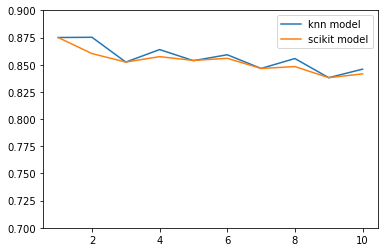

In [175]:
r_values = range(1, 11)
compare_models(normalize(X), y, k_values, r_values, use_kdtree=True)

In [195]:
def find_radius(X, y, lower, upper, eps):
    l = float(lower)
    r = float(upper)
    
    loo_cache = dict()
    
    while r - l > eps:
        m_l = l + (r-l)/3
        m_r = r - (r-l)/2
        
        m_l_res = loo_cache[m_l] = leave_one_out(RNN_model(m_l, use_kdtree=True), X, y)        
        m_r_res = loo_cache[m_r] = leave_one_out(RNN_model(m_r, use_kdtree=True), X, y)
        
#         print (m_l, m_l_res)
#         print (m_r, m_r_res)

        if m_l_res < m_r_res:
            l = m_l
        else:
            r = m_r
    
    res = sorted(loo_cache.items(), key=lambda x:x[0])
    plt.plot([v[0] for v in res], [v[1] for v in res])
    
    return l, loo_cache[l]

 [Elapsed Time: 0:00:37] 100%|###############################| (Time: 0:00:37) 
 [Elapsed Time: 0:00:39] 100%|###############################| (Time: 0:00:39) 
 [Elapsed Time: 0:00:41] 100%|###############################| (Time: 0:00:41) 
 [Elapsed Time: 0:00:42] 100%|###############################| (Time: 0:00:42) 
 [Elapsed Time: 0:00:39] 100%|###############################| (Time: 0:00:39) 
 [Elapsed Time: 0:00:40] 100%|###############################| (Time: 0:00:40) 
 [Elapsed Time: 0:00:37] 100%|###############################| (Time: 0:00:37) 
 [Elapsed Time: 0:00:38] 100%|###############################| (Time: 0:00:38) 
 [Elapsed Time: 0:00:38] 100%|###############################| (Time: 0:00:38) 
 [Elapsed Time: 0:00:38] 100%|###############################| (Time: 0:00:38) 
 [Elapsed Time: 0:00:37] 100%|###############################| (Time: 0:00:37) 
 [Elapsed Time: 0:00:37] 100%|###############################| (Time: 0:00:37) 
 [Elapsed Time: 0:00:37] 100%|##########

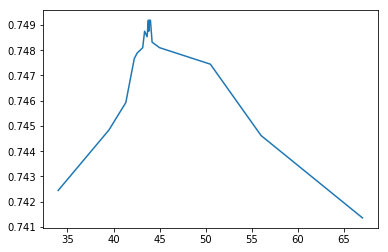

In [196]:
best_radius, accuracy = find_radius(X, y, 1., 100., eps=0.05)

 [Elapsed Time: 0:01:36] 100%|###############################| (Time: 0:01:36) 
 [Elapsed Time: 0:01:39] 100%|###############################| (Time: 0:01:39) 
 [Elapsed Time: 0:01:40] 100%|###############################| (Time: 0:01:40) 
 [Elapsed Time: 0:01:41] 100%|###############################| (Time: 0:01:41) 
 [Elapsed Time: 0:01:38] 100%|###############################| (Time: 0:01:38) 
 [Elapsed Time: 0:01:39] 100%|###############################| (Time: 0:01:39) 
 [Elapsed Time: 0:01:39] 100%|###############################| (Time: 0:01:39) 
 [Elapsed Time: 0:01:40] 100%|###############################| (Time: 0:01:40) 
 [Elapsed Time: 0:01:39] 100%|###############################| (Time: 0:01:39) 
 [Elapsed Time: 0:01:39] 100%|###############################| (Time: 0:01:39) 
 [Elapsed Time: 0:01:39] 100%|###############################| (Time: 0:01:39) 
 [Elapsed Time: 0:01:39] 100%|###############################| (Time: 0:01:39) 
 [Elapsed Time: 0:01:38] 100%|##########

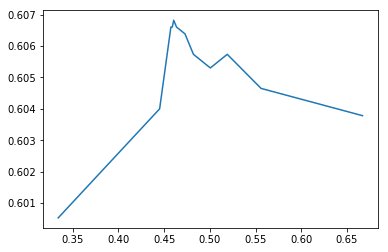

In [199]:
best_radius, accuracy = find_radius(normalize(X), y, 0.001, 1., eps=0.005)